In [105]:
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import glob
import time
import numpy as np
import pandas as pd
import mmcv, cv2
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
from IPython import display
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
Image.__version__

'6.2.1'

In [7]:
device = torch.device('cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [91]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.7):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [185]:
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, post_process=False, thresholds = [0.9, 0.9, 0.9], device=device).eval()

# Load facial recognition model, but I didn't want to use it yet
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [92]:
input_size = 512
output_size = 1
hidden_dim = 25
n_layers = 10
# Load our own model
model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
model.load_state_dict(torch.load('model_1face.pt'))

<All keys matched successfully>

In [9]:
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces    


def process_faces(faces, resnet):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = resnet(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
#     centroid = embeddings.mean(dim=0)
#     x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
    return embeddings

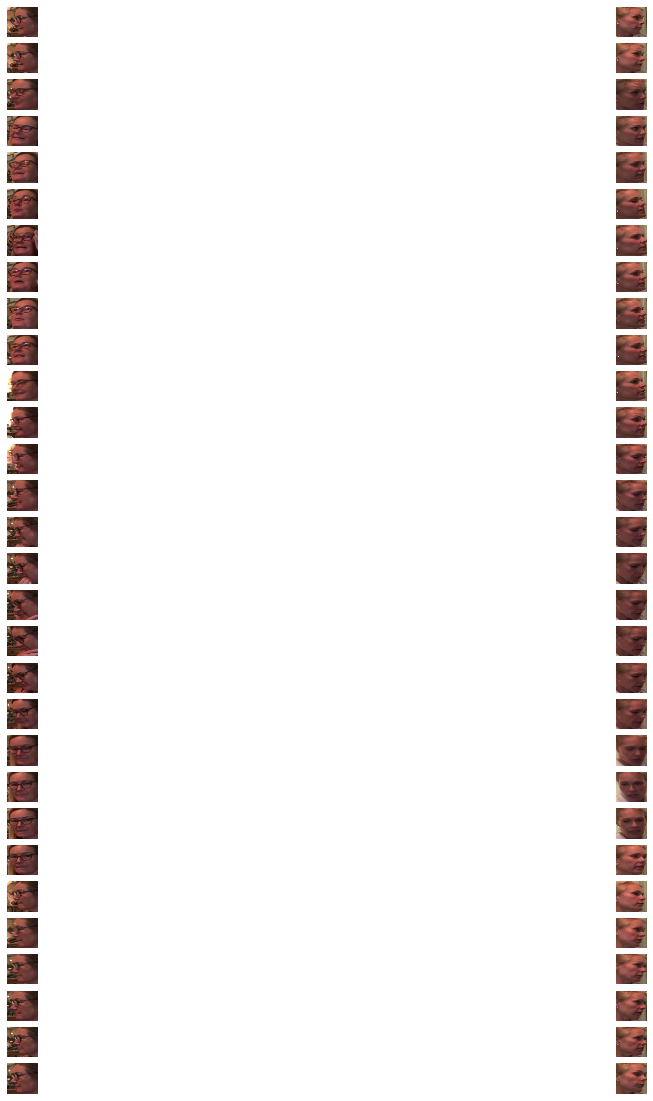

In [40]:
fig, axes = plt.subplots(30, 2, figsize=(20, 20))

for j, face in enumerate(faces):
    axes[j, 0].imshow(face[0].permute(1,2,0).int().numpy())
    axes[j, 1].imshow(face[1].permute(1,2,0).int().numpy())
    axes[j, 0].axis('off')
    axes[j, 1].axis('off')
    
fig.show()

# plt.imshow(faces[5][1].permute(1,2,0).int().numpy())

In [178]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, resize=None, n_frames=30)

# Get all test videos
filenames = glob.glob('data/test_videos//*.mp4')
# metadata = pd.read_json('data/train_sample_videos/metadata.json').T

Y = []
start = time.time()
n_processed = 0
with torch.no_grad():
    for i, filename in tqdm(enumerate(filenames), total=len(filenames)):
        try:
            # Load frames and find faces
            detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, resize=None, n_frames=30)
#             filename = filenames[1]
            faces = detection_pipeline(filename)
            X = process_faces(faces, resnet)
            X = X.to(device)
            test_loader = DataLoader(TensorDataset(torch.stack([X])), shuffle=True, batch_size=1)
            print(len(X))
            if len(X) == 30:
                val_h = model.init_hidden(1)
                val_h = tuple([each.data for each in val_h])
                inp = torch.stack([X]).to(device)
                out, val_h = model(inp, val_h)
                y = out.squeeze().data.numpy().item(0)
            elif len(X) == 30:
                X1 = X[np.arange(1, 60, 2)]
                X2 = X[np.arange(0, 59, 2)]
                val_h = model.init_hidden(1)
                val_h = tuple([each.data for each in val_h])
                inp = torch.stack([X1]).to(device)
                out, val_h = model(inp, val_h)
                y1 = out.squeeze().data.numpy().item(0)
                inp = torch.stack([X2]).to(device)
                out, val_h = model(inp, val_h)
                y2 = out.squeeze().data.numpy().item(0)
                y = np.max([y1, y2])
            else:
                y = .1
            Y.append(y)
        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print(e)
        
        n_processed += len(faces)

print(time.time() - start)




  0%|          | 0/400 [00:00<?, ?it/s]


  0%|          | 1/400 [00:12<1:23:06, 12.50s/it]

29





  0%|          | 2/400 [00:33<1:40:07, 15.10s/it]

30





  1%|          | 3/400 [00:54<1:52:08, 16.95s/it]

60





  1%|          | 4/400 [01:06<1:41:51, 15.43s/it]

30





  1%|▏         | 5/400 [01:22<1:41:49, 15.47s/it]

31





  2%|▏         | 6/400 [01:44<1:54:14, 17.40s/it]

60





  2%|▏         | 7/400 [01:57<1:45:16, 16.07s/it]

30





  2%|▏         | 8/400 [02:09<1:37:32, 14.93s/it]

29





  2%|▏         | 9/400 [02:25<1:39:17, 15.24s/it]

30





  2%|▎         | 10/400 [02:39<1:37:23, 14.98s/it]

30





  3%|▎         | 11/400 [02:55<1:38:10, 15.14s/it]

30





  3%|▎         | 12/400 [03:10<1:37:28, 15.07s/it]

26





  3%|▎         | 13/400 [03:28<1:43:46, 16.09s/it]

30





  4%|▎         | 14/400 [03:42<1:38:24, 15.30s/it]

30





  4%|▍         | 15/400 [03:54<1:32:50, 14.47s/it]

28





  4%|▍         | 16/400 [04:11<1:37:31, 15.24s/it]

30





  4%|▍         | 17/400 [04:23<1:30:55, 14.25s/it]

30





  4%|▍         | 18/400 [04:36<1:28:28, 13.90s/it]

30





  5%|▍         | 19/400 [04:50<1:27:12, 13.73s/it]

20





  5%|▌         | 20/400 [05:09<1:38:37, 15.57s/it]

32





  5%|▌         | 21/400 [05:22<1:32:08, 14.59s/it]

22





  6%|▌         | 22/400 [05:35<1:29:46, 14.25s/it]

30





  6%|▌         | 23/400 [05:48<1:26:36, 13.78s/it]

30





  6%|▌         | 24/400 [06:03<1:28:33, 14.13s/it]

29





  6%|▋         | 25/400 [06:16<1:27:19, 13.97s/it]

29





  6%|▋         | 26/400 [06:34<1:34:31, 15.16s/it]

21





  7%|▋         | 27/400 [07:04<2:01:22, 19.52s/it]

30





  7%|▋         | 28/400 [07:33<2:18:10, 22.29s/it]

30





  7%|▋         | 29/400 [07:58<2:23:17, 23.17s/it]

22





  8%|▊         | 30/400 [08:21<2:22:13, 23.06s/it]

30





  8%|▊         | 31/400 [08:51<2:35:29, 25.28s/it]

30





  8%|▊         | 32/400 [09:17<2:36:28, 25.51s/it]

30





  8%|▊         | 33/400 [10:06<3:17:39, 32.32s/it]

59





  8%|▊         | 34/400 [10:54<3:46:24, 37.12s/it]

60





  9%|▉         | 35/400 [11:16<3:17:40, 32.49s/it]

30





  9%|▉         | 36/400 [11:58<3:35:38, 35.55s/it]

30





  9%|▉         | 37/400 [12:22<3:14:12, 32.10s/it]

30





 10%|▉         | 38/400 [12:49<3:03:16, 30.38s/it]

29





 10%|▉         | 39/400 [13:17<2:59:19, 29.80s/it]

30





 10%|█         | 40/400 [13:42<2:50:20, 28.39s/it]

29





 10%|█         | 41/400 [14:03<2:35:59, 26.07s/it]

30





 10%|█         | 42/400 [14:27<2:32:00, 25.48s/it]

31





 11%|█         | 43/400 [14:54<2:34:40, 26.00s/it]

30





 11%|█         | 44/400 [15:14<2:23:20, 24.16s/it]

30





 11%|█▏        | 45/400 [16:05<3:11:01, 32.29s/it]

60





 12%|█▏        | 46/400 [16:27<2:51:39, 29.09s/it]

30





 12%|█▏        | 47/400 [16:49<2:39:27, 27.10s/it]

25





 12%|█▏        | 48/400 [17:17<2:39:13, 27.14s/it]

30





 12%|█▏        | 49/400 [17:36<2:25:23, 24.85s/it]

15





 12%|█▎        | 50/400 [17:57<2:16:59, 23.48s/it]

30





 13%|█▎        | 51/400 [18:16<2:09:44, 22.30s/it]

30





 13%|█▎        | 52/400 [18:45<2:20:55, 24.30s/it]

30





 13%|█▎        | 53/400 [19:11<2:24:06, 24.92s/it]

30





 14%|█▎        | 54/400 [19:36<2:22:26, 24.70s/it]

30





 14%|█▍        | 55/400 [19:59<2:19:54, 24.33s/it]

30





 14%|█▍        | 56/400 [20:21<2:15:34, 23.65s/it]

30





 14%|█▍        | 57/400 [20:41<2:09:22, 22.63s/it]

30





 14%|█▍        | 58/400 [21:07<2:14:57, 23.68s/it]

30





 15%|█▍        | 59/400 [21:35<2:20:33, 24.73s/it]

31





 15%|█▌        | 60/400 [22:05<2:28:54, 26.28s/it]

30





 15%|█▌        | 61/400 [22:27<2:22:49, 25.28s/it]

30





 16%|█▌        | 62/400 [22:50<2:18:24, 24.57s/it]

30





 16%|█▌        | 63/400 [23:10<2:09:08, 22.99s/it]

29





 16%|█▌        | 64/400 [23:35<2:12:36, 23.68s/it]

30





 16%|█▋        | 65/400 [23:59<2:12:16, 23.69s/it]

30





 16%|█▋        | 66/400 [24:28<2:22:00, 25.51s/it]

31





 17%|█▋        | 67/400 [24:50<2:15:03, 24.33s/it]

29





 17%|█▋        | 68/400 [25:16<2:16:49, 24.73s/it]

30





 17%|█▋        | 69/400 [25:44<2:22:44, 25.87s/it]

30





 18%|█▊        | 70/400 [26:05<2:14:19, 24.42s/it]

26





 18%|█▊        | 71/400 [26:24<2:03:48, 22.58s/it]

30





 18%|█▊        | 72/400 [26:45<2:02:13, 22.36s/it]

30





 18%|█▊        | 73/400 [27:11<2:06:21, 23.19s/it]

25





 18%|█▊        | 74/400 [27:32<2:03:24, 22.71s/it]

29





 19%|█▉        | 75/400 [28:13<2:33:19, 28.31s/it]

30





 19%|█▉        | 76/400 [28:38<2:25:54, 27.02s/it]

30





 19%|█▉        | 77/400 [29:04<2:24:48, 26.90s/it]

30





 20%|█▉        | 78/400 [29:28<2:19:02, 25.91s/it]

30





 20%|█▉        | 79/400 [29:54<2:18:53, 25.96s/it]

30





 20%|██        | 80/400 [30:16<2:12:46, 24.89s/it]

30





 20%|██        | 81/400 [30:41<2:12:31, 24.93s/it]

30





 20%|██        | 82/400 [31:04<2:08:12, 24.19s/it]

10





 21%|██        | 83/400 [31:28<2:07:31, 24.14s/it]

30





 21%|██        | 84/400 [32:03<2:24:15, 27.39s/it]

30





 21%|██▏       | 85/400 [32:23<2:12:16, 25.19s/it]

30





 22%|██▏       | 86/400 [32:47<2:09:40, 24.78s/it]

29





 22%|██▏       | 87/400 [33:05<1:58:57, 22.80s/it]

30





 22%|██▏       | 88/400 [33:26<1:56:32, 22.41s/it]

28





 22%|██▏       | 89/400 [33:42<1:45:22, 20.33s/it]

16





 22%|██▎       | 90/400 [34:06<1:51:07, 21.51s/it]

29





 23%|██▎       | 91/400 [34:33<1:59:12, 23.15s/it]

30





 23%|██▎       | 92/400 [34:56<1:59:17, 23.24s/it]

30





 23%|██▎       | 93/400 [35:18<1:56:02, 22.68s/it]

30





 24%|██▎       | 94/400 [35:38<1:52:35, 22.08s/it]

30





 24%|██▍       | 95/400 [36:10<2:06:29, 24.88s/it]

30





 24%|██▍       | 96/400 [36:31<2:00:16, 23.74s/it]

29





 24%|██▍       | 97/400 [36:58<2:05:34, 24.87s/it]

30





 24%|██▍       | 98/400 [37:09<1:43:13, 20.51s/it]

14





 25%|██▍       | 99/400 [37:20<1:29:23, 17.82s/it]

30





 25%|██▌       | 100/400 [37:56<1:55:27, 23.09s/it]

30





 25%|██▌       | 101/400 [38:32<2:14:18, 26.95s/it]

60





 26%|██▌       | 102/400 [39:05<2:22:46, 28.75s/it]

30





 26%|██▌       | 103/400 [39:43<2:37:15, 31.77s/it]

30





 26%|██▌       | 104/400 [40:07<2:25:13, 29.44s/it]

30





 26%|██▋       | 105/400 [40:31<2:16:04, 27.68s/it]

30





 26%|██▋       | 106/400 [40:57<2:12:58, 27.14s/it]

30





 27%|██▋       | 107/400 [41:24<2:12:28, 27.13s/it]

29





 27%|██▋       | 108/400 [41:44<2:02:09, 25.10s/it]

28





 27%|██▋       | 109/400 [42:30<2:32:13, 31.39s/it]

30





 28%|██▊       | 110/400 [42:58<2:26:22, 30.28s/it]

30





 28%|██▊       | 111/400 [43:21<2:14:44, 27.97s/it]

29





 28%|██▊       | 112/400 [43:53<2:20:05, 29.19s/it]

32





 28%|██▊       | 113/400 [44:19<2:15:53, 28.41s/it]

30





 28%|██▊       | 114/400 [44:36<1:58:54, 24.95s/it]

29





 29%|██▉       | 115/400 [45:02<1:59:04, 25.07s/it]

30





 29%|██▉       | 116/400 [45:25<1:56:20, 24.58s/it]

30





 29%|██▉       | 117/400 [46:01<2:11:35, 27.90s/it]

30





 30%|██▉       | 118/400 [46:28<2:09:44, 27.61s/it]

30





 30%|██▉       | 119/400 [46:49<1:59:59, 25.62s/it]

30





 30%|███       | 120/400 [47:13<1:58:01, 25.29s/it]

30





 30%|███       | 121/400 [47:39<1:58:46, 25.54s/it]

30





 30%|███       | 122/400 [48:02<1:54:30, 24.71s/it]

30





 31%|███       | 123/400 [48:24<1:50:24, 23.92s/it]

30





 31%|███       | 124/400 [48:47<1:48:33, 23.60s/it]

30





 31%|███▏      | 125/400 [49:11<1:48:49, 23.74s/it]

30





 32%|███▏      | 126/400 [49:37<1:51:08, 24.34s/it]

30





 32%|███▏      | 127/400 [50:03<1:52:51, 24.80s/it]

30





 32%|███▏      | 128/400 [50:25<1:49:02, 24.05s/it]

30





 32%|███▏      | 129/400 [50:47<1:46:38, 23.61s/it]

31





 32%|███▎      | 130/400 [51:14<1:49:37, 24.36s/it]

25





 33%|███▎      | 131/400 [51:31<1:39:36, 22.22s/it]

16





 33%|███▎      | 132/400 [51:54<1:40:35, 22.52s/it]

30





 33%|███▎      | 133/400 [52:46<2:19:31, 31.35s/it]

60





 34%|███▎      | 134/400 [53:11<2:10:29, 29.43s/it]

30





 34%|███▍      | 135/400 [53:57<2:31:48, 34.37s/it]

60





 34%|███▍      | 136/400 [54:38<2:39:36, 36.28s/it]

30





 34%|███▍      | 137/400 [55:02<2:24:04, 32.87s/it]

30





 34%|███▍      | 138/400 [55:24<2:08:04, 29.33s/it]

30





 35%|███▍      | 139/400 [55:51<2:04:58, 28.73s/it]

30





 35%|███▌      | 140/400 [56:24<2:10:41, 30.16s/it]

55





 35%|███▌      | 141/400 [56:47<2:00:10, 27.84s/it]

30





 36%|███▌      | 142/400 [57:13<1:57:07, 27.24s/it]

30





 36%|███▌      | 143/400 [57:34<1:49:36, 25.59s/it]

30





 36%|███▌      | 144/400 [57:49<1:35:47, 22.45s/it]

30





 36%|███▋      | 145/400 [58:47<2:20:30, 33.06s/it]

60





 36%|███▋      | 146/400 [59:10<2:06:52, 29.97s/it]

15





 37%|███▋      | 147/400 [59:35<1:59:44, 28.40s/it]

24





 37%|███▋      | 148/400 [59:56<1:50:01, 26.20s/it]

30





 37%|███▋      | 149/400 [1:00:17<1:43:38, 24.78s/it]

30





 38%|███▊      | 150/400 [1:00:53<1:56:47, 28.03s/it]

30





 38%|███▊      | 151/400 [1:01:14<1:47:35, 25.93s/it]

23





 38%|███▊      | 152/400 [1:01:38<1:44:13, 25.22s/it]

30





 38%|███▊      | 153/400 [1:02:06<1:47:40, 26.15s/it]

30





 38%|███▊      | 154/400 [1:02:36<1:52:21, 27.40s/it]

30





 39%|███▉      | 155/400 [1:03:01<1:48:54, 26.67s/it]

30





 39%|███▉      | 156/400 [1:03:26<1:45:41, 25.99s/it]

51





 39%|███▉      | 157/400 [1:03:50<1:43:42, 25.61s/it]

30





 40%|███▉      | 158/400 [1:04:10<1:36:06, 23.83s/it]

28





 40%|███▉      | 159/400 [1:04:46<1:51:02, 27.65s/it]

30





 40%|████      | 160/400 [1:05:04<1:38:37, 24.65s/it]

30





 40%|████      | 161/400 [1:05:28<1:36:41, 24.27s/it]

30





 40%|████      | 162/400 [1:05:52<1:36:05, 24.22s/it]

30





 41%|████      | 163/400 [1:06:18<1:38:40, 24.98s/it]

26





 41%|████      | 164/400 [1:06:41<1:34:53, 24.12s/it]

16





 41%|████▏     | 165/400 [1:07:03<1:32:39, 23.66s/it]

29





 42%|████▏     | 166/400 [1:07:25<1:30:41, 23.25s/it]

23





 42%|████▏     | 167/400 [1:07:58<1:40:52, 25.97s/it]

30





 42%|████▏     | 168/400 [1:08:29<1:46:30, 27.55s/it]

21





 42%|████▏     | 169/400 [1:09:09<2:00:14, 31.23s/it]

30





 42%|████▎     | 170/400 [1:09:34<1:52:45, 29.42s/it]

30





 43%|████▎     | 171/400 [1:09:58<1:46:00, 27.78s/it]

25





 43%|████▎     | 172/400 [1:10:27<1:46:49, 28.11s/it]

30





 43%|████▎     | 173/400 [1:10:47<1:37:27, 25.76s/it]

30





 44%|████▎     | 174/400 [1:11:09<1:33:15, 24.76s/it]

13





 44%|████▍     | 175/400 [1:11:36<1:35:00, 25.34s/it]

30





 44%|████▍     | 176/400 [1:12:00<1:32:37, 24.81s/it]

30





 44%|████▍     | 177/400 [1:12:24<1:31:08, 24.52s/it]

30





 44%|████▍     | 178/400 [1:12:51<1:33:22, 25.24s/it]

54





 45%|████▍     | 179/400 [1:13:10<1:26:18, 23.43s/it]

30





 45%|████▌     | 180/400 [1:13:52<1:46:42, 29.10s/it]

30





 45%|████▌     | 181/400 [1:14:19<1:44:04, 28.51s/it]

30





 46%|████▌     | 182/400 [1:15:04<2:00:57, 33.29s/it]

30





 46%|████▌     | 183/400 [1:15:24<1:46:02, 29.32s/it]

30





 46%|████▌     | 184/400 [1:15:42<1:34:08, 26.15s/it]

25





 46%|████▋     | 185/400 [1:15:59<1:23:06, 23.19s/it]

24





 46%|████▋     | 186/400 [1:16:25<1:26:28, 24.25s/it]

16





 47%|████▋     | 187/400 [1:16:48<1:23:45, 23.59s/it]

30





 47%|████▋     | 188/400 [1:17:14<1:25:55, 24.32s/it]

28





 47%|████▋     | 189/400 [1:17:38<1:25:53, 24.42s/it]

30





 48%|████▊     | 190/400 [1:18:04<1:27:20, 24.96s/it]

30





 48%|████▊     | 191/400 [1:18:26<1:23:14, 23.90s/it]

30





 48%|████▊     | 192/400 [1:19:26<2:01:03, 34.92s/it]

30





 48%|████▊     | 193/400 [1:19:55<1:54:04, 33.07s/it]

30





 48%|████▊     | 194/400 [1:20:18<1:43:18, 30.09s/it]

30





 49%|████▉     | 195/400 [1:20:39<1:33:24, 27.34s/it]

30





 49%|████▉     | 196/400 [1:20:59<1:25:10, 25.05s/it]

30





 49%|████▉     | 197/400 [1:21:23<1:23:27, 24.67s/it]

30





 50%|████▉     | 198/400 [1:21:44<1:19:50, 23.71s/it]

30





 50%|████▉     | 199/400 [1:22:06<1:17:34, 23.15s/it]

29





 50%|█████     | 200/400 [1:22:28<1:15:28, 22.64s/it]

30





 50%|█████     | 201/400 [1:22:53<1:17:35, 23.39s/it]

25





 50%|█████     | 202/400 [1:23:17<1:18:09, 23.68s/it]

30





 51%|█████     | 203/400 [1:23:41<1:17:36, 23.64s/it]

23





 51%|█████     | 204/400 [1:24:06<1:18:41, 24.09s/it]

30





 51%|█████▏    | 205/400 [1:24:26<1:14:41, 22.98s/it]

23





 52%|█████▏    | 206/400 [1:24:48<1:13:42, 22.79s/it]

30





 52%|█████▏    | 207/400 [1:25:16<1:18:09, 24.30s/it]

30





 52%|█████▏    | 208/400 [1:25:43<1:19:51, 24.95s/it]

30





 52%|█████▏    | 209/400 [1:26:08<1:20:03, 25.15s/it]

30





 52%|█████▎    | 210/400 [1:26:30<1:15:57, 23.99s/it]

30





 53%|█████▎    | 211/400 [1:26:47<1:09:13, 21.98s/it]

30





 53%|█████▎    | 212/400 [1:27:18<1:17:21, 24.69s/it]

30





 53%|█████▎    | 213/400 [1:27:36<1:11:06, 22.82s/it]

30





 54%|█████▎    | 214/400 [1:28:02<1:13:44, 23.79s/it]

30





 54%|█████▍    | 215/400 [1:28:28<1:14:56, 24.31s/it]

30





 54%|█████▍    | 216/400 [1:28:54<1:16:23, 24.91s/it]

30





 54%|█████▍    | 217/400 [1:29:19<1:15:26, 24.73s/it]

30





 55%|█████▍    | 218/400 [1:29:44<1:15:34, 24.91s/it]

30





 55%|█████▍    | 219/400 [1:30:08<1:14:24, 24.66s/it]

30





 55%|█████▌    | 220/400 [1:30:33<1:14:26, 24.81s/it]

30





 55%|█████▌    | 221/400 [1:30:59<1:15:07, 25.18s/it]

30





 56%|█████▌    | 222/400 [1:31:22<1:12:23, 24.40s/it]

25





 56%|█████▌    | 223/400 [1:31:42<1:08:05, 23.08s/it]

30





 56%|█████▌    | 224/400 [1:32:05<1:08:07, 23.22s/it]

30





 56%|█████▋    | 225/400 [1:32:35<1:13:29, 25.19s/it]

30





 56%|█████▋    | 226/400 [1:33:25<1:34:56, 32.74s/it]

60





 57%|█████▋    | 227/400 [1:33:51<1:28:32, 30.71s/it]

30





 57%|█████▋    | 228/400 [1:34:18<1:24:21, 29.43s/it]

30





 57%|█████▋    | 229/400 [1:34:45<1:22:03, 28.79s/it]

30





 57%|█████▊    | 230/400 [1:35:08<1:16:04, 26.85s/it]

29





 58%|█████▊    | 231/400 [1:35:36<1:16:52, 27.29s/it]

13





 58%|█████▊    | 232/400 [1:36:00<1:13:39, 26.31s/it]

30





 58%|█████▊    | 233/400 [1:36:47<1:30:41, 32.59s/it]

60





 58%|█████▊    | 234/400 [1:37:08<1:20:20, 29.04s/it]

27





 59%|█████▉    | 235/400 [1:37:33<1:16:37, 27.86s/it]

30





 59%|█████▉    | 236/400 [1:37:58<1:13:51, 27.02s/it]

25





 59%|█████▉    | 237/400 [1:38:24<1:12:35, 26.72s/it]

30





 60%|█████▉    | 238/400 [1:39:14<1:31:09, 33.76s/it]

30





 60%|█████▉    | 239/400 [1:39:40<1:24:10, 31.37s/it]

30





 60%|██████    | 240/400 [1:40:05<1:18:45, 29.53s/it]

29





 60%|██████    | 241/400 [1:40:43<1:24:29, 31.88s/it]

30





 60%|██████    | 242/400 [1:41:16<1:25:14, 32.37s/it]

60





 61%|██████    | 243/400 [1:41:38<1:16:26, 29.21s/it]

30





 61%|██████    | 244/400 [1:41:57<1:08:03, 26.18s/it]

30





 61%|██████▏   | 245/400 [1:42:21<1:05:50, 25.49s/it]

24





 62%|██████▏   | 246/400 [1:42:44<1:03:17, 24.66s/it]

30





 62%|██████▏   | 247/400 [1:43:05<1:00:14, 23.62s/it]

30





 62%|██████▏   | 248/400 [1:43:31<1:01:54, 24.44s/it]

30





 62%|██████▏   | 249/400 [1:44:15<1:16:15, 30.30s/it]

60





 62%|██████▎   | 250/400 [1:44:38<1:10:18, 28.12s/it]

27





 63%|██████▎   | 251/400 [1:45:16<1:17:01, 31.02s/it]

30





 63%|██████▎   | 252/400 [1:45:32<1:05:18, 26.48s/it]

30





 63%|██████▎   | 253/400 [1:46:00<1:05:41, 26.82s/it]

30





 64%|██████▎   | 254/400 [1:46:30<1:07:57, 27.93s/it]

30





 64%|██████▍   | 255/400 [1:46:53<1:03:37, 26.32s/it]

25





 64%|██████▍   | 256/400 [1:47:16<1:00:54, 25.38s/it]

30





 64%|██████▍   | 257/400 [1:47:36<56:51, 23.86s/it]  

30





 64%|██████▍   | 258/400 [1:48:01<57:07, 24.14s/it]

27





 65%|██████▍   | 259/400 [1:48:48<1:13:14, 31.16s/it]

60





 65%|██████▌   | 260/400 [1:49:09<1:04:56, 27.83s/it]

30





 65%|██████▌   | 261/400 [1:49:38<1:05:36, 28.32s/it]

9





 66%|██████▌   | 262/400 [1:49:57<59:01, 25.66s/it]  

13





 66%|██████▌   | 263/400 [1:50:24<59:04, 25.87s/it]

30





 66%|██████▌   | 264/400 [1:50:51<59:25, 26.21s/it]

11





 66%|██████▋   | 265/400 [1:51:14<56:55, 25.30s/it]

25





 66%|██████▋   | 266/400 [1:51:45<1:00:03, 26.89s/it]

30





 67%|██████▋   | 267/400 [1:52:03<54:01, 24.37s/it]  

30





 67%|██████▋   | 268/400 [1:52:45<1:05:28, 29.76s/it]

30





 67%|██████▋   | 269/400 [1:53:13<1:03:20, 29.01s/it]

25





 68%|██████▊   | 270/400 [1:53:39<1:01:06, 28.20s/it]

30





 68%|██████▊   | 271/400 [1:54:09<1:01:37, 28.66s/it]

30





 68%|██████▊   | 272/400 [1:55:06<1:19:17, 37.17s/it]

60





 68%|██████▊   | 273/400 [1:55:25<1:07:08, 31.72s/it]

30





 68%|██████▊   | 274/400 [1:55:47<1:00:47, 28.95s/it]

30





 69%|██████▉   | 275/400 [1:56:10<56:21, 27.05s/it]  

30





 69%|██████▉   | 276/400 [1:56:30<51:42, 25.02s/it]

27





 69%|██████▉   | 277/400 [1:56:55<51:16, 25.01s/it]

26





 70%|██████▉   | 278/400 [1:57:49<1:08:25, 33.65s/it]

61





 70%|██████▉   | 279/400 [1:58:11<1:00:39, 30.08s/it]

30





 70%|███████   | 280/400 [1:58:54<1:07:50, 33.92s/it]

30





 70%|███████   | 281/400 [1:59:13<58:41, 29.59s/it]  

30





 70%|███████   | 282/400 [1:59:36<54:23, 27.66s/it]

30





 71%|███████   | 283/400 [2:00:01<52:19, 26.84s/it]

30





 71%|███████   | 284/400 [2:00:28<51:41, 26.74s/it]

32





 71%|███████▏  | 285/400 [2:00:45<45:59, 24.00s/it]

30





 72%|███████▏  | 286/400 [2:00:59<39:53, 20.99s/it]

24





 72%|███████▏  | 287/400 [2:01:20<39:39, 21.06s/it]

30





 72%|███████▏  | 288/400 [2:01:44<40:35, 21.75s/it]

30





 72%|███████▏  | 289/400 [2:02:05<39:39, 21.43s/it]

15





 72%|███████▎  | 290/400 [2:02:45<49:42, 27.11s/it]

30





 73%|███████▎  | 291/400 [2:03:11<48:49, 26.88s/it]

31





 73%|███████▎  | 292/400 [2:03:45<51:58, 28.87s/it]

30





 73%|███████▎  | 293/400 [2:04:08<48:40, 27.30s/it]

30





 74%|███████▎  | 294/400 [2:04:48<54:48, 31.02s/it]

30





 74%|███████▍  | 295/400 [2:05:15<52:07, 29.79s/it]

59





 74%|███████▍  | 296/400 [2:05:34<46:15, 26.68s/it]

16





 74%|███████▍  | 297/400 [2:06:00<45:25, 26.46s/it]

30





 74%|███████▍  | 298/400 [2:06:27<45:00, 26.47s/it]

31





 75%|███████▍  | 299/400 [2:07:12<53:51, 31.99s/it]

30





 75%|███████▌  | 300/400 [2:07:39<50:57, 30.57s/it]

18





 75%|███████▌  | 301/400 [2:08:06<48:36, 29.46s/it]

30





 76%|███████▌  | 302/400 [2:08:29<45:00, 27.56s/it]

30





 76%|███████▌  | 303/400 [2:09:13<52:34, 32.52s/it]

60





 76%|███████▌  | 304/400 [2:09:39<48:54, 30.56s/it]

30





 76%|███████▋  | 305/400 [2:10:06<46:44, 29.52s/it]

30





 76%|███████▋  | 306/400 [2:10:24<40:44, 26.00s/it]

30





 77%|███████▋  | 307/400 [2:11:05<47:11, 30.45s/it]

30





 77%|███████▋  | 308/400 [2:11:28<43:30, 28.37s/it]

30





 77%|███████▋  | 309/400 [2:11:50<40:00, 26.38s/it]

30





 78%|███████▊  | 310/400 [2:12:15<38:45, 25.83s/it]

28





 78%|███████▊  | 311/400 [2:12:39<37:45, 25.45s/it]

30





 78%|███████▊  | 312/400 [2:13:03<36:27, 24.86s/it]

30





 78%|███████▊  | 313/400 [2:13:44<43:06, 29.73s/it]

30





 78%|███████▊  | 314/400 [2:14:06<39:28, 27.55s/it]

30





 79%|███████▉  | 315/400 [2:14:25<35:25, 25.01s/it]

30





 79%|███████▉  | 316/400 [2:14:48<34:03, 24.33s/it]

29





 79%|███████▉  | 317/400 [2:15:05<30:43, 22.21s/it]

30





 80%|███████▉  | 318/400 [2:15:43<36:44, 26.89s/it]

30





 80%|███████▉  | 319/400 [2:16:09<35:52, 26.57s/it]

30





 80%|████████  | 320/400 [2:16:28<32:29, 24.37s/it]

30





 80%|████████  | 321/400 [2:16:52<31:59, 24.30s/it]

30





 80%|████████  | 322/400 [2:17:12<29:50, 22.96s/it]

30





 81%|████████  | 323/400 [2:17:29<27:13, 21.22s/it]

27





 81%|████████  | 324/400 [2:17:49<26:29, 20.92s/it]

16





 81%|████████▏ | 325/400 [2:18:10<25:50, 20.67s/it]

30





 82%|████████▏ | 326/400 [2:18:34<26:52, 21.79s/it]

30





 82%|████████▏ | 327/400 [2:19:03<29:01, 23.85s/it]

30





 82%|████████▏ | 328/400 [2:19:51<37:17, 31.07s/it]

60





 82%|████████▏ | 329/400 [2:20:16<34:52, 29.48s/it]

30





 82%|████████▎ | 330/400 [2:20:40<32:15, 27.65s/it]

30





 83%|████████▎ | 331/400 [2:21:07<31:43, 27.59s/it]

30





 83%|████████▎ | 332/400 [2:21:32<30:20, 26.77s/it]

30





 83%|████████▎ | 333/400 [2:21:53<28:07, 25.19s/it]

30





 84%|████████▎ | 334/400 [2:22:20<28:17, 25.72s/it]

30





 84%|████████▍ | 335/400 [2:22:57<31:14, 28.84s/it]

30





 84%|████████▍ | 336/400 [2:23:26<30:48, 28.88s/it]

30





 84%|████████▍ | 337/400 [2:23:48<28:10, 26.83s/it]

30





 84%|████████▍ | 338/400 [2:24:11<26:34, 25.71s/it]

30





 85%|████████▍ | 339/400 [2:24:42<27:46, 27.32s/it]

31





 85%|████████▌ | 340/400 [2:25:07<26:34, 26.58s/it]

30





 85%|████████▌ | 341/400 [2:25:33<26:12, 26.65s/it]

30





 86%|████████▌ | 342/400 [2:25:53<23:46, 24.59s/it]

29





 86%|████████▌ | 343/400 [2:26:18<23:32, 24.78s/it]

23





 86%|████████▌ | 344/400 [2:26:41<22:32, 24.15s/it]

16





 86%|████████▋ | 345/400 [2:27:04<21:46, 23.76s/it]

30





 86%|████████▋ | 346/400 [2:27:27<21:09, 23.50s/it]

30





 87%|████████▋ | 347/400 [2:27:54<21:36, 24.47s/it]

30





 87%|████████▋ | 348/400 [2:28:21<21:57, 25.34s/it]

30





 87%|████████▋ | 349/400 [2:28:47<21:43, 25.56s/it]

29





 88%|████████▊ | 350/400 [2:29:09<20:28, 24.57s/it]

30





 88%|████████▊ | 351/400 [2:29:31<19:23, 23.75s/it]

30





 88%|████████▊ | 352/400 [2:29:52<18:18, 22.89s/it]

30





 88%|████████▊ | 353/400 [2:30:14<17:40, 22.57s/it]

30





 88%|████████▊ | 354/400 [2:30:33<16:35, 21.65s/it]

30





 89%|████████▉ | 355/400 [2:30:53<15:45, 21.02s/it]

17





 89%|████████▉ | 356/400 [2:31:38<20:47, 28.36s/it]

60





 89%|████████▉ | 357/400 [2:32:06<20:09, 28.14s/it]

30





 90%|████████▉ | 358/400 [2:32:28<18:30, 26.44s/it]

30





 90%|████████▉ | 359/400 [2:32:56<18:16, 26.75s/it]

30





 90%|█████████ | 360/400 [2:33:15<16:22, 24.56s/it]

30





 90%|█████████ | 361/400 [2:33:40<16:00, 24.62s/it]

20





 90%|█████████ | 362/400 [2:34:11<16:47, 26.51s/it]

30





 91%|█████████ | 363/400 [2:34:35<15:49, 25.67s/it]

30





 91%|█████████ | 364/400 [2:35:18<18:28, 30.78s/it]

30





 91%|█████████▏| 365/400 [2:35:36<15:47, 27.06s/it]

30





 92%|█████████▏| 366/400 [2:36:03<15:17, 26.99s/it]

30





 92%|█████████▏| 367/400 [2:36:26<14:11, 25.80s/it]

30





 92%|█████████▏| 368/400 [2:36:53<13:57, 26.19s/it]

32





 92%|█████████▏| 369/400 [2:37:14<12:40, 24.54s/it]

26





 92%|█████████▎| 370/400 [2:37:45<13:16, 26.56s/it]

30





 93%|█████████▎| 371/400 [2:38:13<13:03, 27.00s/it]

30





 93%|█████████▎| 372/400 [2:38:32<11:27, 24.54s/it]

12





 93%|█████████▎| 373/400 [2:39:05<12:17, 27.32s/it]

30





 94%|█████████▎| 374/400 [2:39:24<10:39, 24.61s/it]

30





 94%|█████████▍| 375/400 [2:39:46<09:54, 23.77s/it]

24





 94%|█████████▍| 376/400 [2:40:38<12:54, 32.25s/it]

30





 94%|█████████▍| 377/400 [2:41:03<11:32, 30.09s/it]

30





 94%|█████████▍| 378/400 [2:41:25<10:08, 27.67s/it]

30





 95%|█████████▍| 379/400 [2:41:48<09:16, 26.50s/it]

30





 95%|█████████▌| 380/400 [2:42:09<08:16, 24.82s/it]

30





 95%|█████████▌| 381/400 [2:42:39<08:19, 26.31s/it]

31





 96%|█████████▌| 382/400 [2:43:01<07:32, 25.11s/it]

30





 96%|█████████▌| 383/400 [2:43:16<06:11, 21.83s/it]

30





 96%|█████████▌| 384/400 [2:43:33<05:28, 20.53s/it]

30





 96%|█████████▋| 385/400 [2:44:04<05:56, 23.77s/it]

30





 96%|█████████▋| 386/400 [2:44:29<05:34, 23.88s/it]

25





 97%|█████████▋| 387/400 [2:44:52<05:08, 23.74s/it]

30





 97%|█████████▋| 388/400 [2:45:18<04:53, 24.48s/it]

30





 97%|█████████▋| 389/400 [2:45:43<04:30, 24.55s/it]

30





 98%|█████████▊| 390/400 [2:46:09<04:09, 24.96s/it]

30





 98%|█████████▊| 391/400 [2:46:39<03:57, 26.40s/it]

19





 98%|█████████▊| 392/400 [2:47:03<03:27, 25.90s/it]

29





 98%|█████████▊| 393/400 [2:47:49<03:43, 31.96s/it]

60





 98%|█████████▊| 394/400 [2:48:19<03:08, 31.38s/it]

31





 99%|█████████▉| 395/400 [2:48:33<02:09, 25.95s/it]

31





 99%|█████████▉| 396/400 [2:48:52<01:35, 23.90s/it]

30





 99%|█████████▉| 397/400 [2:49:21<01:16, 25.40s/it]

30





100%|█████████▉| 398/400 [2:49:46<00:50, 25.39s/it]

60





100%|█████████▉| 399/400 [2:50:34<00:32, 32.21s/it]

59





100%|██████████| 400/400 [2:50:56<00:00, 29.10s/it]

30
10256.56962442398


In [179]:
torch.save(mtcnn.state_dict(), './mtcnn.pt')

In [180]:
torch.save(resnet.state_dict(), './resnet.pt')